<font size="22"> Exploring the Relationship: Predicting Diabetes Risk through Clinical Trial Data Project Report</font> 

<font size="5"> Group 31: Alton Ho, Ivy Feng, Jasmine Li, Marshal Shuai Zhang</font> 

Introduction:

The Akimel O'odham, also known as Pima, are a group of native Americans that reside in Arizona. According to Knowler et al. (1983), Non-insulin-dependent diabetes mellitus is a common disease in the Pima Indians. It is familial and strongly related to obesity. Similar research found that there may be insulin resistance among Pima Indians, due to a combination of genetic defects and obesity-induced changes in the biophysical properties of skeletal muscles. 
Diabetes is a widespread health concern, demanding proactive strategies for early detection and intervention. This report explores a practical question: "Can we predict a new patient's likelihood of having diabetes based on blood glucose, BMI, age and number of pregnancies?" We aim to cut through the complexity and leverage these common health indicators to build a straightforward model for identifying diabetes risk among Pima Indian women.
High blood glucose, BMI, and age are known factors linked to diabetes. Our study uses real-world data from diverse individuals and employs statistical analyses and machine learning to uncover patterns. The goal is to develop a tool that clinicians can use for early identification and targeted intervention.
This report seeks not just to contribute to Pima Indian diabetes research but also to make a real impact in clinical settings, promoting early detection, personalized care, and better outcomes for patients.
Final Question: Is the new patient likely to have diabetes based on their blood glucose, BMI, and age, number of pregnancies? The reasoning behind choosing these four parameters will be explained below.


In [1]:
#importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(dplyr) 
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

The data we are using is taken from Kaggle, originally from the National Institute of Diabetes and Digestive and Kidney Diseases. Measurements were taken from 768 patients who were females at least 21 years old of Pima Indian heritage. 

- **Pregnancies** represent the number of times an individual has been pregnant. 
- **Glucose** represents plasma glucose concentration for 2 hours in an oral glucose tolerance test. 
- **Blood Pressure** is ​​Diastolic blood pressure measurement (mm Hg). 
- **Skin thickness** measures the Triceps skin fold thickness (mm).
- **Insulin** indicates 2-Hour serum insulin (mu U/ml). 
- **BMI(Body Mass Index)** gives weight in kg/(height in m)², an indicator of a person’s fitness and health level. 
- **Diabetes pedigree function (DPF)** calculates diabetes likelihood depending on the subject's age and his/her diabetic family history. 
- **Age** is the person’s age. 

We will use Blood Glucose, BMI, Age, and Pregnancies as our predictors in the following steps


In [2]:
# Reading the Data from URL
diabetes_data <- read_csv("https://raw.githubusercontent.com/altonho67/dsci-100-2023w1-group-31/main/data/diabetes_2.csv")
#diabetes_data
set.seed(2020)
diabetes_data <- diabetes_data %>%
                 mutate(Outcome = as.factor(Outcome))|>
                 mutate(Outcome = fct_recode(Outcome, "Diabetes" = "1", "None" = "0")) |>
                 mutate_at(c('SkinThickness','Insulin','BloodPressure','Glucose'), ~na_if(., 0)) |>
                 na.omit()                 
head(diabetes_data)
tail(diabetes_data)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,None
0,137,40,35,168,43.1,2.288,33,Diabetes
3,78,50,32,88,31.0,0.248,26,Diabetes
2,197,70,45,543,30.5,0.158,53,Diabetes
1,189,60,23,846,30.1,0.398,59,Diabetes
5,166,72,19,175,25.8,0.587,51,Diabetes


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,121,78,39,74,39.0,0.261,28,None
0,181,88,44,510,43.3,0.222,26,Diabetes
1,128,88,39,110,36.5,1.057,37,Diabetes
2,88,58,26,16,28.4,0.766,22,None
10,101,76,48,180,32.9,0.171,63,None
5,121,72,23,112,26.2,0.245,30,None


In [3]:
#Group diabetes data by their outcomes and summarize the mean of each variable.
diabetes_summary <- diabetes_data |>
                 group_by(Outcome) |>
                 map_df(mean)

diabetes_summary

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.292621,122.6158,70.64631,29.12977,155.8855,33.00204,0.5261196,30.83969,NA


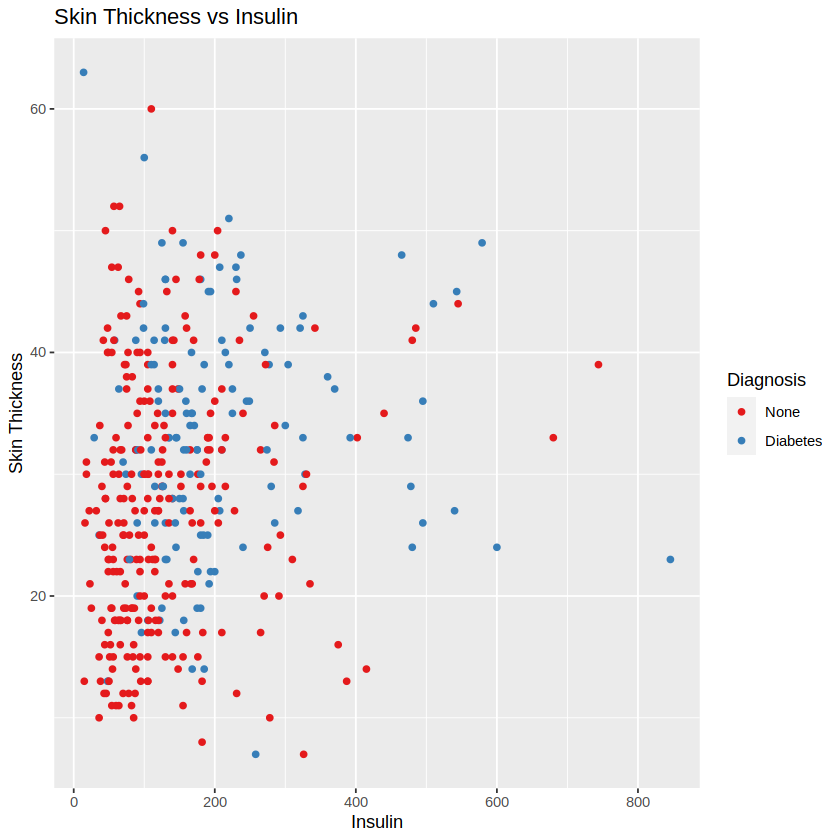

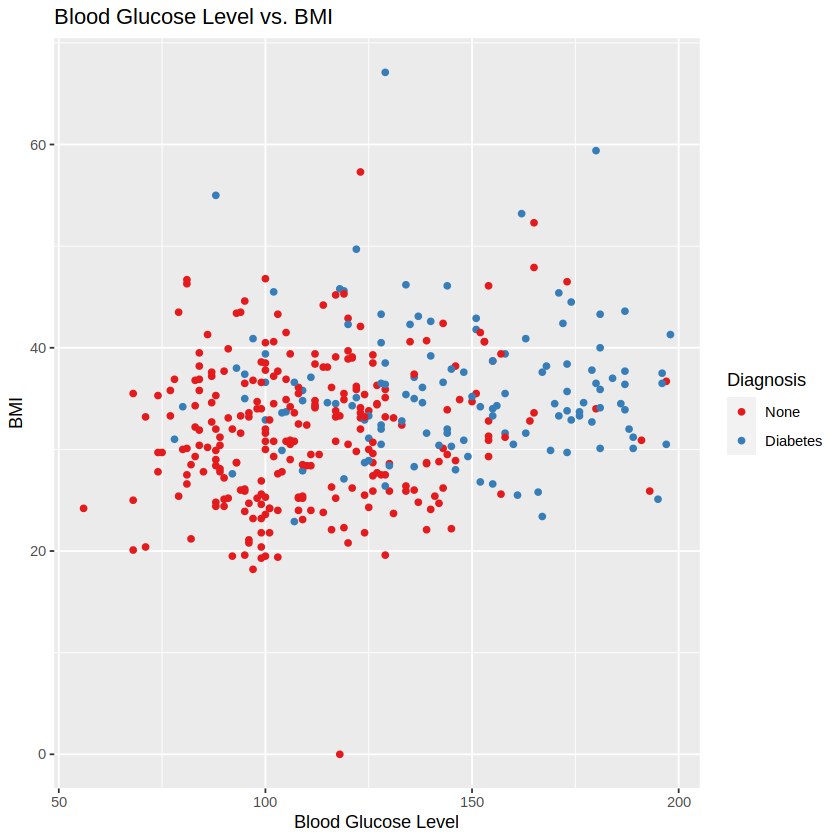

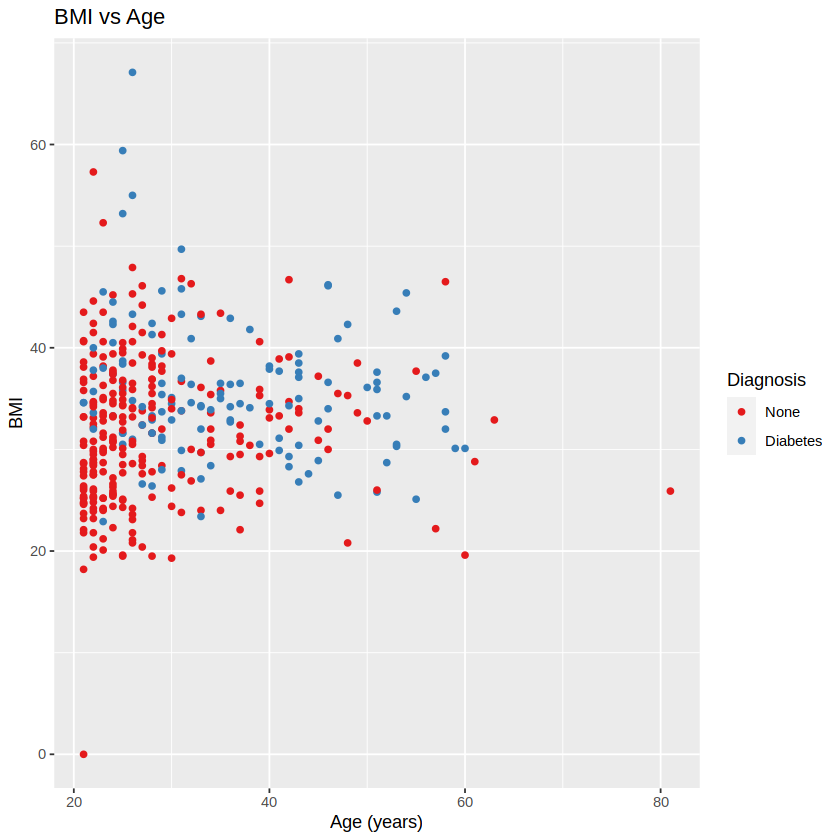

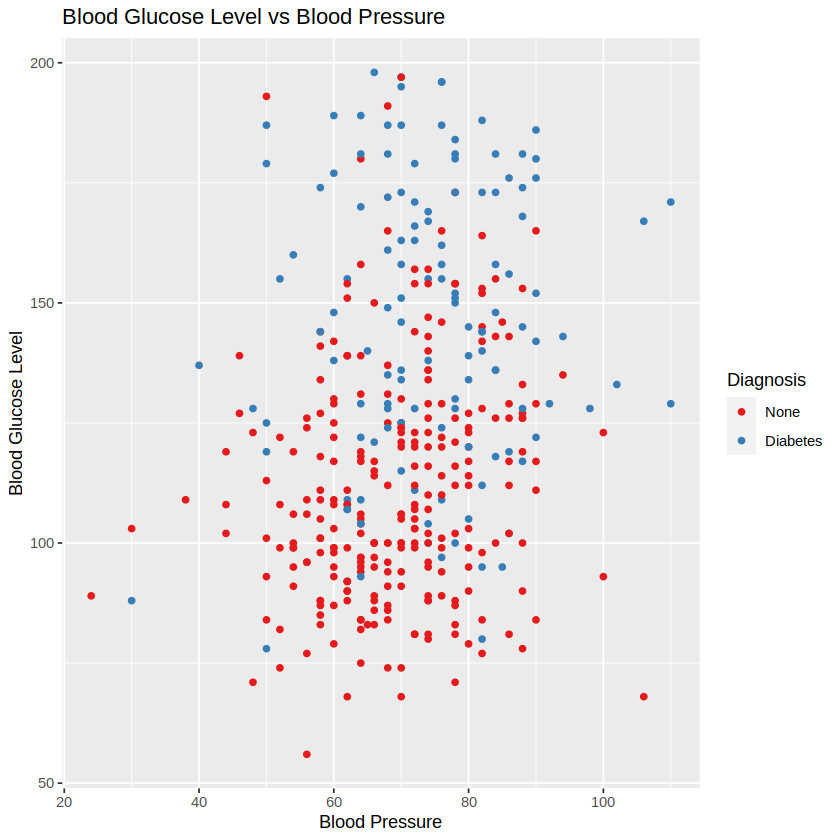

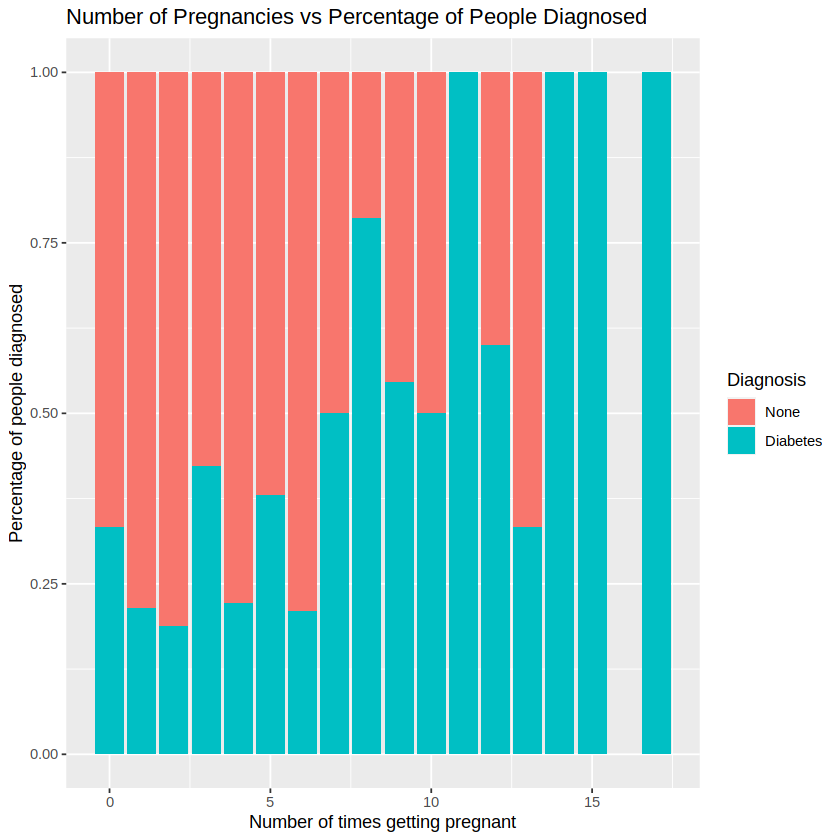

In [4]:
#data visualization for choosing predictor
plot1 <- ggplot(diabetes_data, aes(x = Insulin, y = SkinThickness, color = Outcome)) +
                 geom_point() +
                 labs(x = "Insulin", y = "Skin Thickness", color = "Diagnosis") +
                 ggtitle("Skin Thickness vs Insulin") +
                 scale_color_brewer(palette = "Set1")

plot2 <- ggplot(diabetes_data, aes(x = Glucose, y = BMI, color = Outcome)) +
                 geom_point() +
                 labs(x = "Blood Glucose Level", y = "BMI", color = "Diagnosis") +
                 ggtitle("Blood Glucose Level vs. BMI") +
                 scale_color_brewer(palette = "Set1")

plot3 <- ggplot(diabetes_data, aes(x = Age, y = BMI, color = Outcome)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "BMI", color = "Diagnosis") +
                 ggtitle("BMI vs Age") +
                 scale_color_brewer(palette = "Set1")

plot4 <- ggplot(diabetes_data, aes(x = BloodPressure, y = Glucose, color = Outcome)) +
                 geom_point() +
                 labs(x = "Blood Pressure", y = "Blood Glucose Level", color = "Diagnosis") +
                 ggtitle("Blood Glucose Level vs Blood Pressure") +
                 scale_color_brewer(palette = "Set1")

plot5 <- ggplot(diabetes_data, aes(x = Pregnancies, fill = Outcome,na.rm=TRUE)) +
                 geom_bar(position="fill") +
                 labs(x = "Number of times getting pregnant", y = "Percentage of people diagnosed", fill = "Diagnosis") +
                 ggtitle("Number of Pregnancies vs Percentage of People Diagnosed") +
                 scale_color_brewer(palette = "Set1")


plot1
plot2
plot3
plot4
plot5

Clinical Relevance:

1) Age, BMI, and Glucose are well-established indicators of diabetes risk in clinical settings.
Simplicity and Interpretability:

2) Age, BMI, and Glucose have a relatively strong correlation with the target variable according to Plot 2 and Plot 3. This will help us build the most accurate model.

3) These variables offer a straightforward and easily interpretable model.
Existing Research Support:

4) Extensive research supports the significance of Age, BMI, and Glucose in predicting diabetes.
Feasibility:

5) Age, BMI, and Glucose are practical, easily measurable features in real-world scenarios.
Reducing Model Complexity:

6) Focusing on these key predictors helps avoid overfitting and maintains model simplicity.

7) Plot 6 shows a trend with a higher number of pregnancies leading to higher chances of diabetes diagnosis.

Therefore, our model will be predicting the likelihood of diabetes diagnosis based on Age, BMI, Blood Glucose Level, and the Number of Pregnancies. 

To start with, we imported the tools from library , and set the seed to 2020, to make sure it’s reproducible. 

In order to view our data, we first use the read_csv function to load it. The "Outcome", which is the value we want to predict is dbl(either 1 or 0), but we need to stratify it, so we changed it into a factor. Here, we assigned "1" to  "Diabetes" and "0" to "None"(without diabetes) to predict whether the person has diabetes or not. 

We choose knn classification model to predict, as the thing we want to predict is a categorical variable, which is either diabetes or without diabetes.We split our data into 75% of training and 25% of testing.Moving forward, we will only use the training set until the very end.


In [5]:
set.seed(2020)
#splitting the data for the model
diabetes_split <- initial_split(diabetes_data, prop = 3/4, strata = Outcome)
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split)



<font size="10"> Choose the best K value: </font>

In order to create the classification model, we need to perform the following steps:
1. Create a recipe the training data
2. Create a specification with k-nearest neighbors
3. Split the data into 5 pieces using vfold_cv
4. Split the data into 5 pieces using vfold_cv
5. Perform the validation for k ranges from 0 to 100 to choose the k which provides the best estimation.


In [6]:
set.seed(2020)
#Standardization
diabetes_recipe <- recipe(Outcome ~ Glucose + BMI + Age + Pregnancies, data = diabetes_training)|>
step_scale(all_predictors())|>
step_center(all_predictors())

# Using Knn Model to specify the neighbours we choose( here we use the tune for k neighbours)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
set_engine("kknn")|>
set_mode("classification")

# we now want to choose the best k value for the "neighbors". We first perform 5 fold cross-validation, which calculates the average accuracy of 5 estimations for each k value 
diabetes_vfold <- vfold_cv(diabetes_training, v = 5, strata = Outcome)
# here we specify the k-neighbors' range from 1 to 100,which means we are going to test the k-neighbors from 1 to 100 
grid_vals <- tibble(neighbors = c(1:100))

#workflow which binds our nearest_neighbor and the recipe together, also we added our diabetes_vfold and grid_vals
knn_result <- workflow()|>
add_recipe(diabetes_recipe)|>
add_model(knn_tune)|>
tune_grid(resamples = diabetes_vfold, grid = grid_vals)

#filter for the most accurate neighbor amount (k-value) after constructing a tibble with all the k with their accuracies
accuracy <- knn_result|>
collect_metrics()|>
filter(.metric == "accuracy")|>
select(neighbors, mean)|>
arrange(desc(mean))


head(accuracy)

neighbors,mean
<int>,<dbl>
27,0.8096552
28,0.8096552
17,0.8027586
18,0.8027586
23,0.8027586
24,0.8027586


A k-value of 28 will give us an 80.97% accuracy. A Visualization is below. We usually choose the point K where there is a sharp turn of the curve, and we see when k is at 28, it's a sharp decrease, so we wish to use k=28


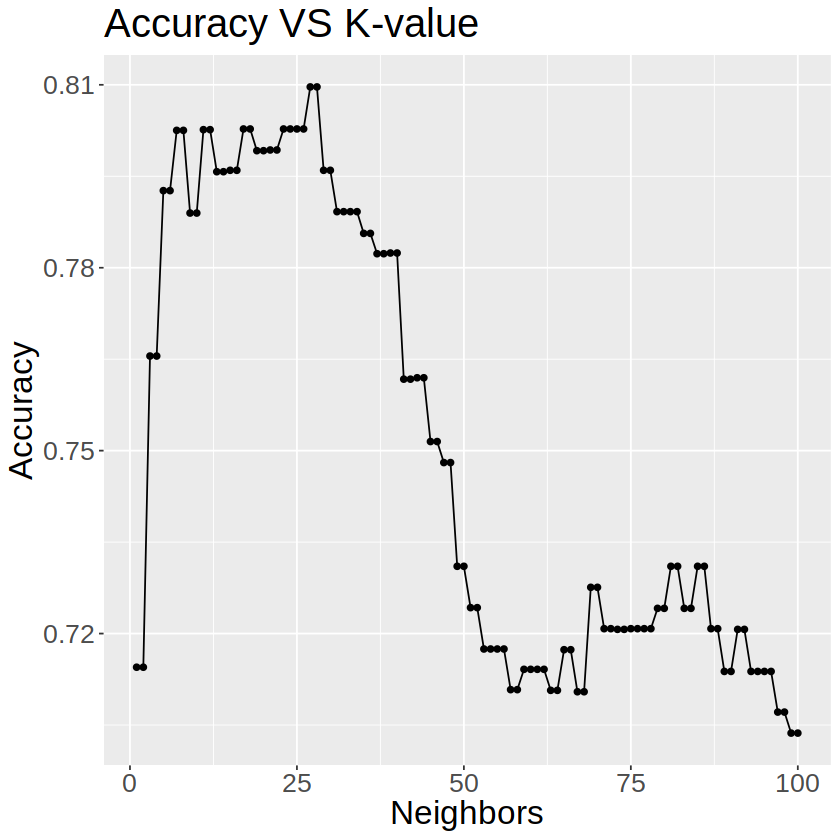

In [7]:
#Visual demonstration on the effect of k-value on accuracy
accuracy_vs_k_plot <- accuracy|>
ggplot(aes(x = neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x = "Neighbors", y = "Accuracy", title = "Accuracy VS K-value")+
theme(text = element_text(size = 20))

accuracy_vs_k_plot

<font size="10"> Build the real classification model: </font>

Now with the new K value, we can just go and classify it again
1. recipe the training data
2. Specify with nearest_neighbor  , and use k=28
3. fit the data into workflow
4. Combine the prediction column to the testing dataset
5. Examine the accuracy of prediction


In [8]:
set.seed(2020)
# now with the new K value, we can just go and classify it again
diabetes_recipe <- recipe(Outcome ~ Glucose + BMI + Age + Pregnancies, data = diabetes_training)|>
step_scale(all_predictors())|>
step_center(all_predictors())

#now we use the new k=28 for neighbors
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 28)|>
set_engine("kknn")|>
set_mode("classification")

#we fit the recipe and nearest_neighbors to the model
diabetes_fit <- workflow()|>
add_recipe(diabetes_recipe)|>
add_model(knn_spec)|>
fit(data = diabetes_training)

diabetes_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(28,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2006803
Best kernel: rectangular
Best k: 28

We used the predict function to predict the outcome (whether people in testing data set have diabetes) using the K nearest neighbor classifier we built before, and used bind_cols to combine the column of predicted value to our original data set.

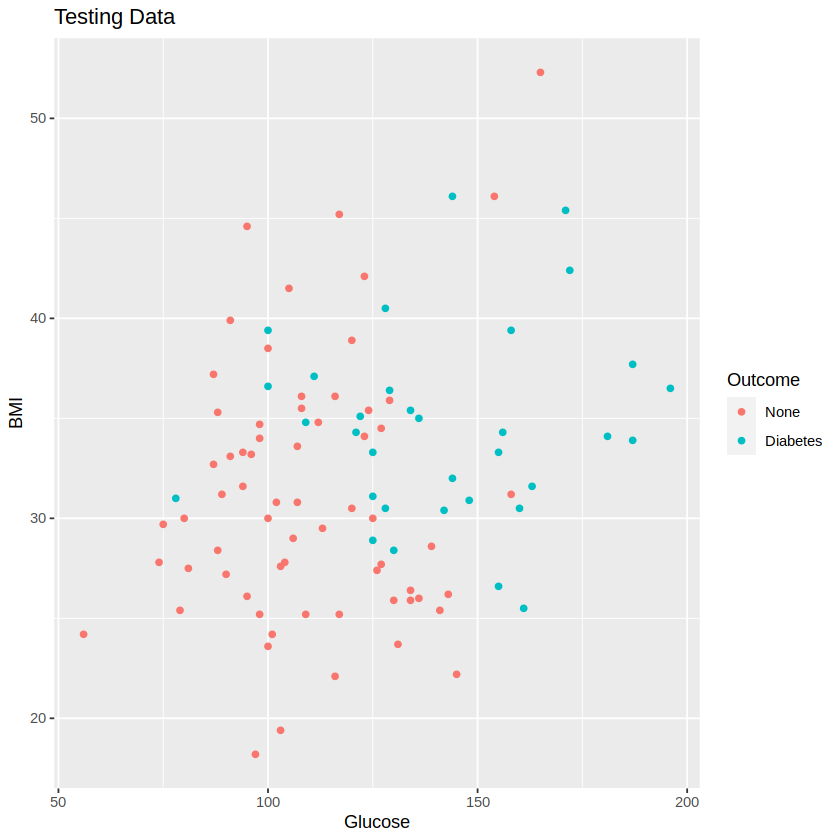

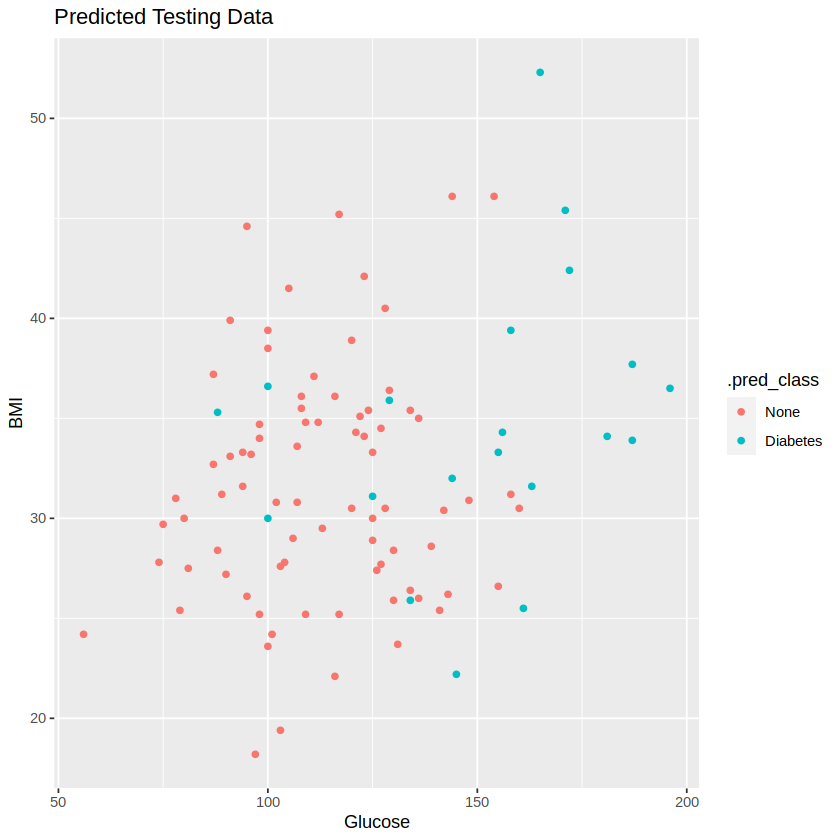

In [9]:
#Visualization for the model
set.seed(2020)
my_predictions <- diabetes_fit|>
  predict(diabetes_testing)|>
  bind_cols(diabetes_testing)
my_predictions %>%
        ggplot(aes(x = Glucose, y = BMI, color = Outcome ))+
        geom_point()+
        ggtitle("Testing Data")
my_predictions %>%
        ggplot(aes(x = Glucose, y = BMI, color = .pred_class ))+
        geom_point()+
        ggtitle("Predicted Testing Data")

In [14]:
# here we use the metrics and accuracy functions to get our accuracy of our prediction, here the accuracy is 0.7474 for the current classification
set.seed(2020)
my_prediction_accuracy <- my_predictions |>
         metrics(truth = Outcome, estimate = .pred_class)|>
         filter(.metric == "accuracy")

my_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7474747


In [11]:
set.seed(2020)
diabetes_mat <- my_predictions |> 
       conf_mat(truth = Outcome, estimate = .pred_class)
diabetes_mat

          Truth
Prediction None Diabetes
  None       60       19
  Diabetes    6       14

Here we construct a table to see how many of the cases on the testing data we have predicted are correct: we have 60 true 
negatives, 19 false positives, 6 false negatives, and 14 true positives.

<font size="10"> Discussion 

<font size="3">Answering the predictive question:</font>

The question we are answering is "Is the new patient likely to have diabetes based on their blood glucose, BMI, and age, number of pregnancies?", and we sucessfully built the classifier to answer this question.

<font size="3">Summarize our findings and compare to our expectations: </font>

We found the age, BMI and blood glucose can give us a relative accurate (75%) model of classification to predict whether a person is diagnosed with diabetes. This is also what we are expected to find, as we had found a relationship between these three predictors when we plotted them on the graph in our group proposal (while we are comparing the graphs of potential predictors such as insulin,skin thickness, BMI, glucose and Ages, we saw a relatively strong relationship between BMI, glucose and Ages)

<font size="3">Model Strengths:</font>

The model is able to predict an individual's likelihood of diagnosing diabetes based on the age, BMI, blood glucose level, and number of pregnancies with a 75% accuracy. The model is well structured, and will be able to develop. 

<font size="3">Limitations and Challenges:</font>

One of the few limitations of our model is that the size of the data set is relatively small with only 763 cases. A small dataset limits model accuracy due to insufficient representation of variability, increased sensitivity to outliers, and a higher risk of overfitting. Complex patterns are harder to discern, and evaluating performance becomes unreliable. The dataset's limited size hinders adequate tuning, feature representation, and overall statistical power. If we can get more data, the model will definitely be more accurate.

<font size="3">Strategies for improving the model:</font>
1) get more data will for sure improve accuracy.
2) choose better predictors.

<font size="3">Clinical Relevance:</font>

The diabetes prediction model presented in this project holds significant promise for clients in clinics by personalizing intervention strategies. Leveraging key indicators such as age, BMI,  number of pregnancies, and glucose levels, the model helps to proactively identify individuals at risk. In the context of our project, this models empowers our healthcare system to keep helping first nation women at risk of diagnosing diabetes. 

What Future Questions Could This Lead To?
1) Can this model help non-aboriginal women in the world?
2) How effective are the treatments and prevention strategies?
3) What predictors can improve our model? 

<font size="10"> References

Knowler, W. C., Pettitt, D. J., Bennett, P. H., & Williams, R. C. (1983). 

    Diabetes mellitus in the Pima Indians: genetic and evolutionary considerations. Am J Phys Anthropol., 62(1), pp. 107-114.
    
    https://pubmed.ncbi.nlm.nih.gov/6624895/#:~:text=It%20is%20familial%20and%20strongly,%2C%20insulin%20resistance%2C%20and%20diabetes.
Lillioja, S., & Bogardus, C. (1988). 

    Insulin resistance in Pima Indians. A combined effect of genetic predisposition and obesity-related skeletal muscle cell hypertrophy. Acta Med Scand Suppl ., 723(1), pp. 103-119. 
    
    https://pubmed.ncbi.nlm.nih.gov/3134799/
AKTURK, M. (n.d.). Diabetes Dataset. Kaggle. Retrieved December 9, 2023, from

    https://www.kaggle.com/datasets/mathchi/diabetes-data-set
